# Image scene classification using FeatureClassifier

> * 🔬 Data Science
> * 🥠 Deep Learning and Object classification

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Download & setting up training data](#Download-&-setting-up-training-data)
* [Train the model](#Train-the-model)
 * [Prepare data](#Prepare-data)
 * [Visualize training data](#Visualize-training-data)
 * [Load model architecture](#Load-model-architecture)
 * [Find an optimal learning rate](#Find-an-optimal-learning-rate)
 * [Fit the model](#Fit-the-model)
 * [Visualize results in validation set](#Visualize-results-in-validation-set)
 * [Accuracy assessment](#Accuracy-assessment)
 * [Save the model](#Save-the-model)
* [Model inference](#Model-inference)
* [Results](#Results)
* [Conclusion](#Conclusion)

## Introduction

In this sample notebook we will be using `ArcGIS API for Python` for training an object classification model on image data from external source and using that model for inferencing in the ArcGIS Pro. 
For this example we will be using the [RESISC45 Dataset](https://arxiv.org/abs/1703.00121) which is a publicly available benchmark for Remote Sensing Image Scene Classification (RESISC), created by Northwestern Polytechnical University (NWPU). This dataset contains 31,500 images, covering 45 scene classes with 700 images in each class. 
We will be using this dataset to train a `FeatureClassifier` model which will classify satellite images tile in 45 scene classes specified in the dataset.

## Necessary imports

In [23]:
import os, json
from arcgis.learn import prepare_data, FeatureClassifier

## Download & setting up training data 

Since [RESISC45 Dataset](https://arxiv.org/abs/1703.00121) is a publically available data so we will be downloading the data available on the [Tensorflow website](https://www.tensorflow.org/datasets/catalog/resisc45).<br>
The data will be downloaded by the name of <b>NWPU-RESISC45.rar</b> <br>
- Citation : `@article{cheng2017remote,
  title={Remote sensing image scene classification: Benchmark and state of the art},
  author={Cheng, Gong and Han, Junwei and Lu, Xiaoqiang},
  journal={Proceedings of the IEEE},
  volume={105},
  number={10},
  pages={1865--1883},
  year={2017},
  publisher={IEEE}
}`

After the data is downloaded then follow the following steps to prepare the model for the `FeatureClassifier`. 
- Extract the rar file
- Create a folder named <b>images</b> and move all the 45 folders (correspoding to each class in the dataset) in images

<img src="data\image_scene_classification_using_FeatureClassifier_data.gif" width="750" align="center">

We will set the path of the folder containing the <b>images</b> in the <b>output_path</b> variable

In [2]:
output_path = os.path.join(os.getcwd(), "NWPU-RESISC45")

## Train the model

`arcgis.learn` provides the ability to determine the class of each feature in the form of a `FeatureClassifier` model. To learn more about it's workings and use cases, see this guide - ["How feature classifier works?"](https://developers.arcgis.com/python/guide/how-feature-categorization-works/).

### Prepare data

Here, we will specify the path to our training data and a few hyperparameters.

- `path`: path of the folder/list of folders containing training data.
- `dataset_type` : The type of dataset getting passed to the Feature Classifier.
- `batch_size`: Number of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card. 128 worked for us on a 32GB GPU.

Since we are using the dataset from external source for training our `FeatureClassifier` we will be using <b>Imagenet</b> as dataset_type.

In [3]:
data = prepare_data(
    path=output_path, dataset_type="Imagenet", batch_size=128, val_split_pct=0.2
)

### Visualize training data

To get a sense of what the training data looks like, the `show_batch()` method randomly picks a few training chips and visualizes them.
- `rows`: Number of rows to visualize

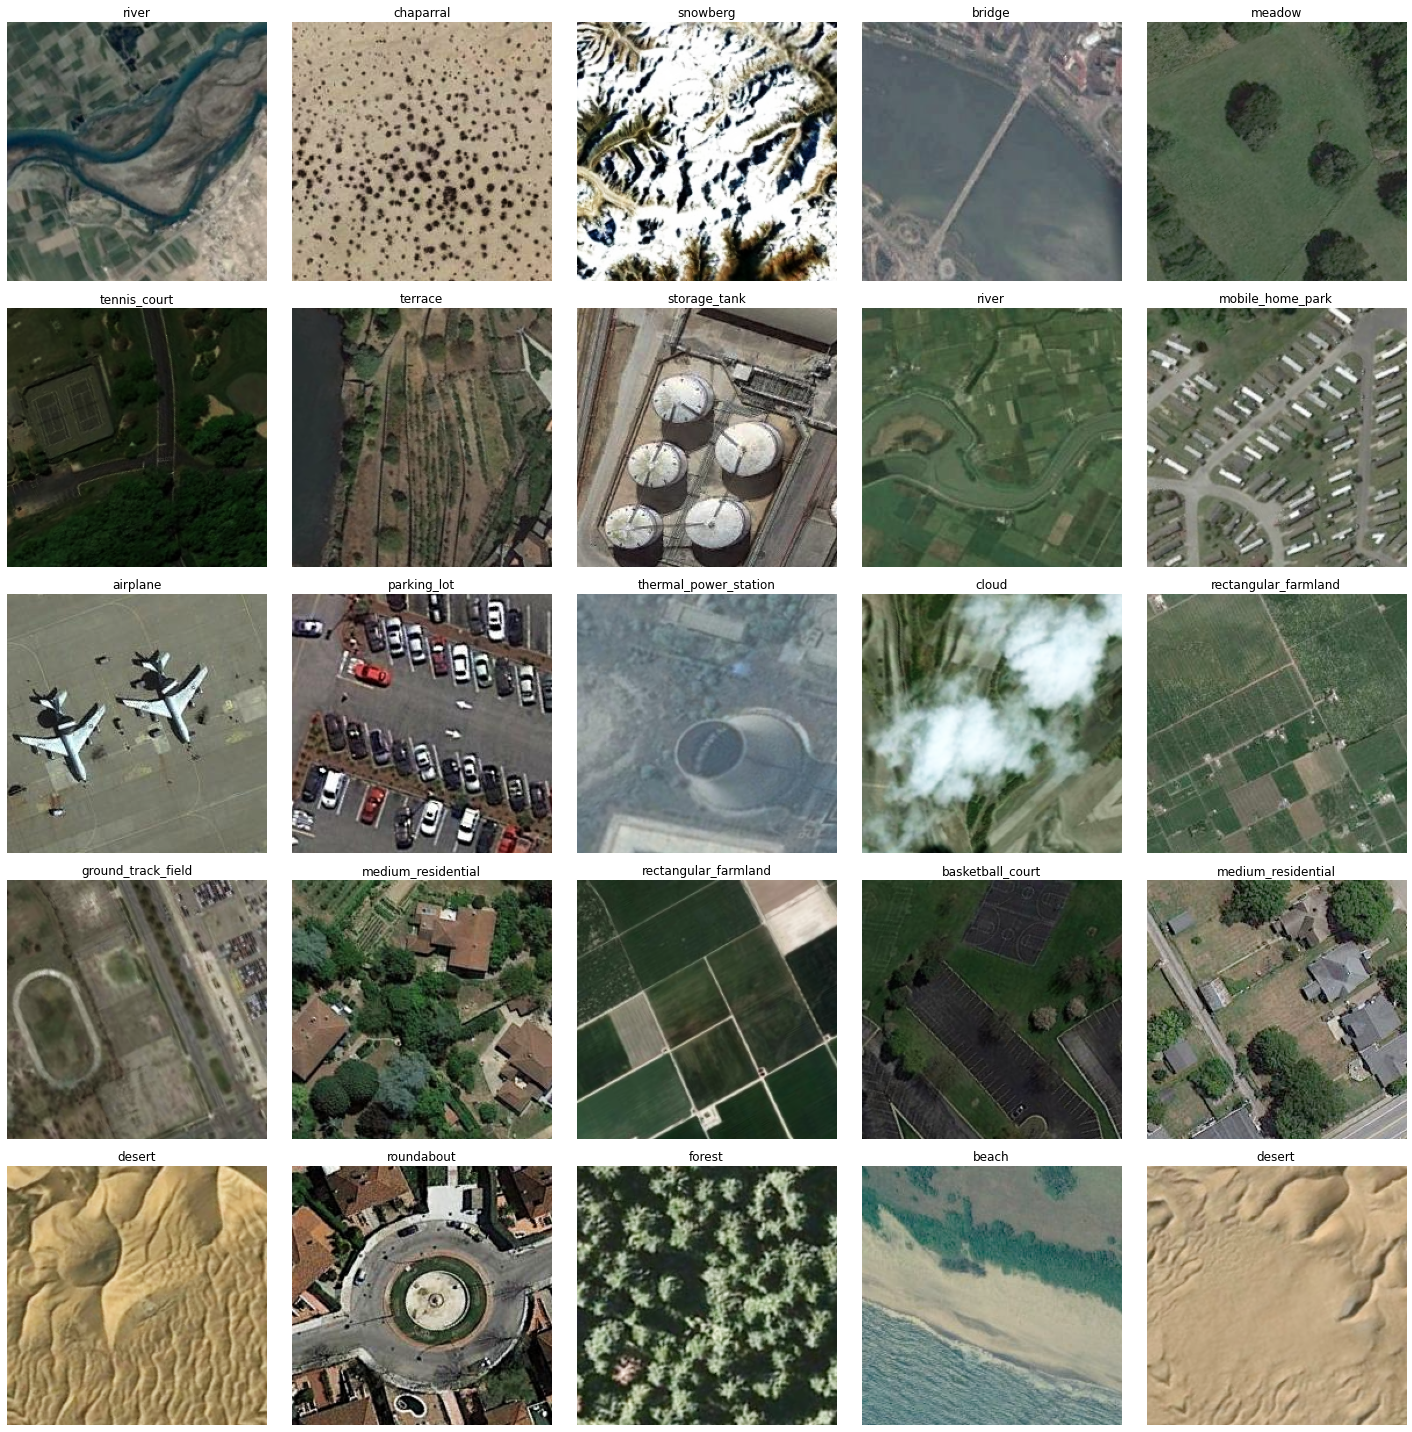

In [4]:
data.show_batch(rows=5)

### Load model architecture

In [5]:
model = FeatureClassifier(data, oversample=True)

### Find an optimal learning rate

[Learning rate](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is one of the most important hyperparameters in model training. `ArcGIS API for Python` provides a learning rate finder that automatically chooses the optimal learning rate for you.

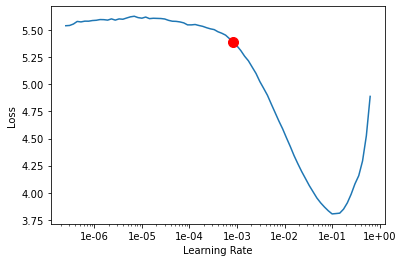

In [6]:
lr = model.lr_find()

### Fit the model 

We will train the model for a few epochs with the learning rate we have found. For the sake of time, we can start with 20 epochs.

In [7]:
model.fit(20, lr=lr)

Here, with only 20 epochs, we can see reasonable results — both training and validation losses have gone down considerably, indicating that the model is learning to classify image scenes.

### Visualize results in validation set

It is a good practice to see the results of the model viz-a-viz ground truth. The code below picks random samples and shows us ground truth and model predictions, side by side. This enables us to preview the results of the model within the notebook.

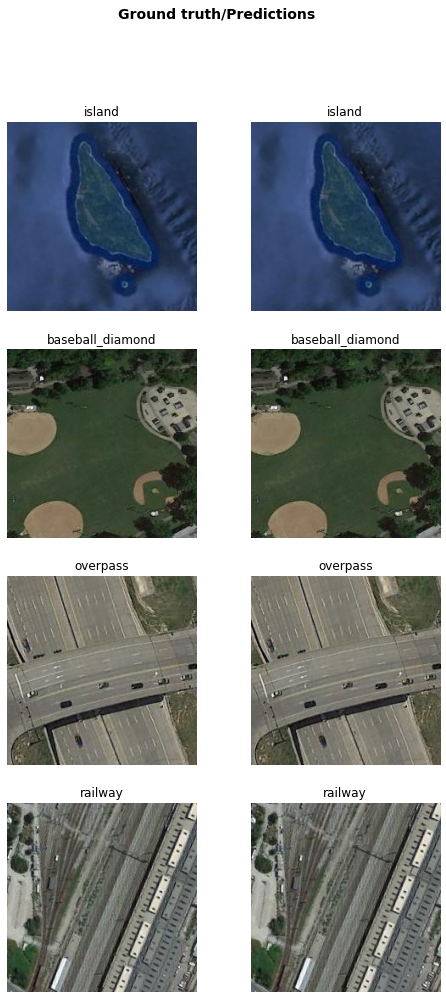

In [8]:
model.show_results(rows=4)

### Accuracy assessment

`arcgis.learn` provides `plot_confusion_matrix()` that plots a confusion matrix of the model predictions to evaluate its accuracy.

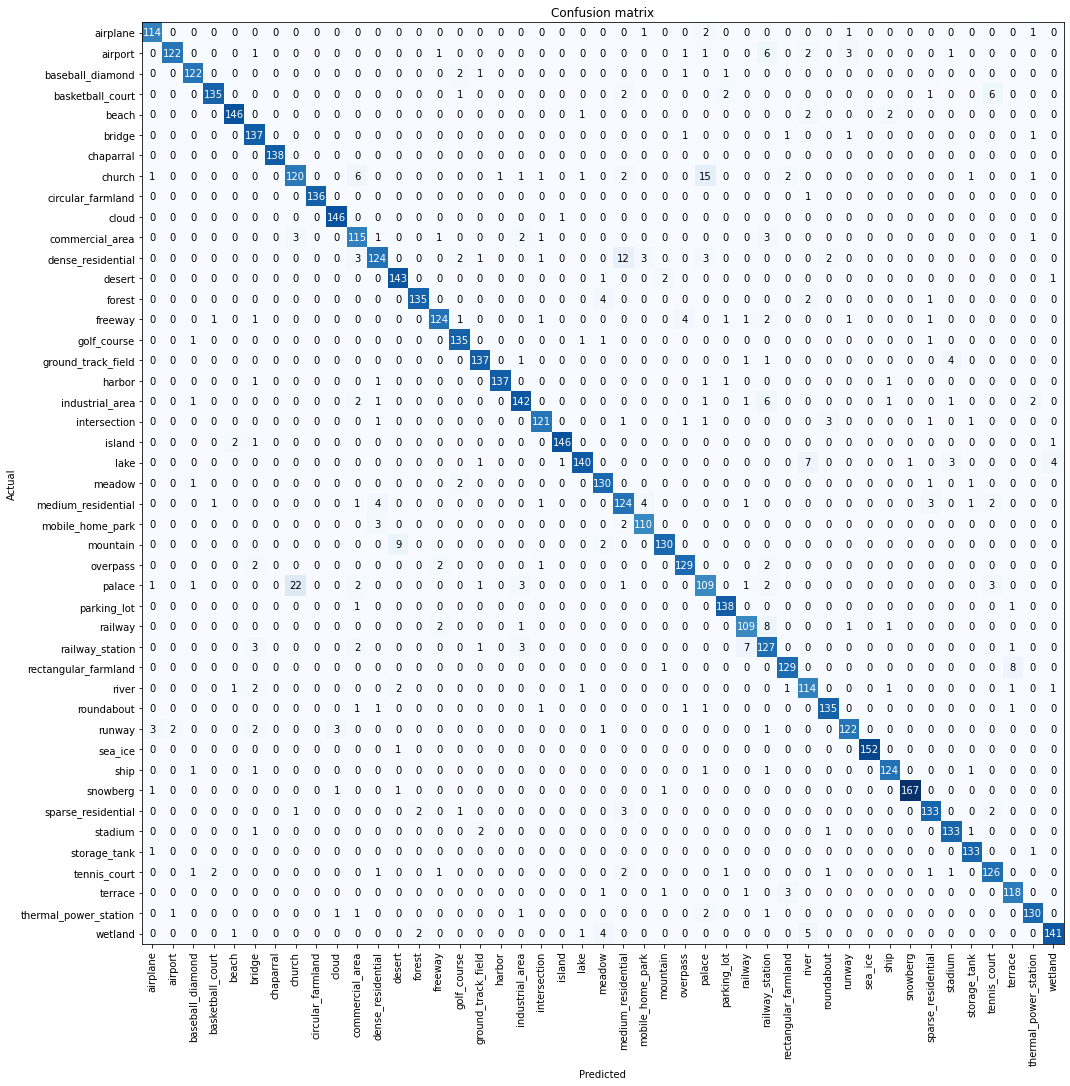

In [9]:
model.plot_confusion_matrix()

The confusion matrix validates that the trained model is learning to classify coastlines. The diagonal numbers show the number of scenes correctly classified to the respective categories.

### Save the model

Now, we will save the model that we trained as a 'Deep Learning Package' ('.dlpk' format). A Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [13]:
model_name = "Nwpu_model1"
model.save(model_name)

WindowsPath('D:/NWPU/NWPU-RESISC45/models/Nwpu_model1')

## Model inference

Before using the model for inference we need to make some changes in the <b>model_name.emd</b> file. You can learn more about this file at this [link](https://github.com/Esri/raster-deep-learning/blob/master/docs/writing_model_definition.md)

By default in EMD the `CropSizeFixed` : 1. Here we need to change the `CropSizeFixed` : 0 so that the size of tile cropped around the feature is not fixed.

In [22]:
with open(
    os.path.join(output_path, "models", model_name, model_name + ".emd"), "r+"
) as emd_file:
    data = json.load(emd_file)
    data["CropSizeFixed"] = 0
    emd_file.seek(0)
    json.dump(data, emd_file, indent=4)
    emd_file.truncate()

In order for us to perform inferencing in ArcGIS Pro, we need to create a feature class on the map using `Create Feature Class` or `Create Fishnet` tool, for an area that is not already seen by the model.

We have also provided the Feature Class and the Model trained on NWPU Dataset for reference. You can directly download those to run experiments from the links given below.
- Feature Class : ["Link"](https://pythonapi.playground.esri.com/portal/home/item.html?id=9ef830048d1a4021819b499b4df431aa)
- NWPU Model : ["Link"](https://pythonapi.playground.esri.com/portal/home/item.html?id=5e18839f2fee4449ad9b486c0bf2cbb0)


Now, we will use the `Classify Objects Using Deep Learning tool` for inferencing the results. The parameters required to run the function are:

- `Input Raster`: World Imagery
- `Input Features`: Output from the `Create Feature Class` or `Create Fishnet` tool.
- `Output CLassified Objects Feature Class`: Output feature class.
- `Model Definition`: Emd file of the model that we trained.
- `Class Label Field`: Field name that will contain the detected class number.
- `Environments`: Set optimum `Cell Size`, `Processing Extent` and `Processor Type`.

We have investigated and found out that `Cell Size` of 1m/pixel works best for this model.  

<img src="data\image_scene_classification_using_FeatureClassifier_screenshot.png" width="750" align="center">

## Results 

We selected an area unseen (by the model) and generated the features in it using the `Create Feature Class` tool. We then used our model for classification. Below are the results that we got.

<img src="data\image_scene_classification_using_FeatureClassifier_output.gif" width="750" align="center">

## Conclusion 

In this notebook, we demonstrated how to use the `FeatureClassifier` model from the `ArcGIS API for Python` to classify image scene using training data from external source.